In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('..')

from src.model import DeepCleanAutoencoder
from src.dataset import GWDataset
from src.utils import postprocess

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

Running on device: cuda


### Config

In [2]:
MODEL_PATH = '../models/best_model.pth'
TEST_DATA_PATH = '../data/test_data.npz' 

# match training
LINEAR = True
SAMPLE_RATE = 2048
BAND_MIN = 80.0      # Target 60Hz mains
BAND_MAX = 1000.0

INFERENCE_OVERLAP = 4.0

### Load Data and Model

In [3]:
data = np.load(TEST_DATA_PATH)
strain_raw = data['strain']
witnesses_raw = data['witnesses']

print(f"Strain Shape: {strain_raw.shape}")
print(f"Witnesses Shape: {witnesses_raw.shape}")

test_dataset = GWDataset(
    strain_raw, 
    witnesses_raw, 
    SAMPLE_RATE, 
    overlap=INFERENCE_OVERLAP, 
    band_start=BAND_MIN, 
    band_end=BAND_MAX,
    linear=LINEAR
)

model = DeepCleanAutoencoder(num_witnesses=witnesses_raw.shape[0]).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded")

Strain Shape: (4194304,)
Witnesses Shape: (5, 4194304)
Model loaded


In [4]:
for key in data.keys():
    print(key)
    print(data[key])

strain
[-8.76266992e-20 -6.50074920e-20 -1.46932143e-19 ... -6.71059657e-19
 -6.67001536e-19 -6.41710078e-19]
witnesses
[[ 3.08672810e+01  3.44549637e+01  3.82058563e+01 ...  3.83053541e+00
   1.62563515e+01  2.52936554e+01]
 [-1.11689995e+02 -1.13331619e+02 -1.18509430e+02 ... -9.73372803e+01
  -1.07772110e+02 -1.11254562e+02]
 [-6.81328354e+01 -8.01825638e+01 -8.74759979e+01 ... -4.23530006e+01
  -5.04486771e+01 -5.75333595e+01]
 [-1.85706024e+01 -1.86819439e+01 -1.87873669e+01 ... -1.86293945e+01
  -1.85790195e+01 -1.85361176e+01]
 [-1.03898859e-02  1.21204668e-01  2.45533472e-01 ...  6.39999558e-01
   5.56650002e-01  4.82507878e-01]]
times
[1.18674056e+09 1.18674056e+09 1.18674056e+09 ... 1.18674159e+09
 1.18674159e+09 1.18674159e+09]
sample_rate
4096
gps_start
1186740564
duration
1024
detector
H1
witness_channels
['H1:PEM-CS_ACC_PSL_TABLE1_X_DQ' 'H1:PEM-CS_ACC_PSL_TABLE1_Y_DQ'
 'H1:PEM-CS_ACC_PSL_TABLE1_Z_DQ' 'H1:PEM-CS_ACC_PSL_TABLE2_Z_DQ']


### Run Inference + post process stuff

In [12]:
import numpy as np
import torch

# Choose a smooth window for overlap-add (Hann)
window = np.hanning(test_dataset.seg_len)

# Preallocate output arrays
total_len = len(strain_raw)
reconstructed = np.zeros(total_len)
weight_sum = np.zeros(total_len)

for segment_idx in range(len(test_dataset)):
    w_tensor, h_tensor_norm = test_dataset[segment_idx]
    w_batch = w_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_normalized = model(w_batch)

    noise_estimate = postprocess(
        pred_normalized,
        test_dataset.strain_mean,
        test_dataset.strain_std,
        SAMPLE_RATE,
        BAND_MIN,
        BAND_MAX,
    )

    # Original segment
    start_idx = test_dataset.indices[segment_idx]
    end_idx = start_idx + test_dataset.seg_len
    segment_original = strain_raw[start_idx:end_idx]

    # Cleaned segment
    segment_cleaned = segment_original - noise_estimate

    # Apply Hann window
    windowed_cleaned = segment_cleaned * window

    # Overlap-add
    reconstructed[start_idx:end_idx] += windowed_cleaned
    weight_sum[start_idx:end_idx] += window

# Normalize to account for overlapping weights
nonzero = weight_sum > 0
reconstructed[nonzero] /= weight_sum[nonzero]

print("Reconstruction complete using dataset segment lengths and overlaps.")


Reconstruction complete using dataset segment lengths and overlaps.


In [10]:
print(segment_original.shape)
print(segment_original.shape[0] / 2048)

(16384,)
8.0


### Actual visualization stuff i dont feel like doing

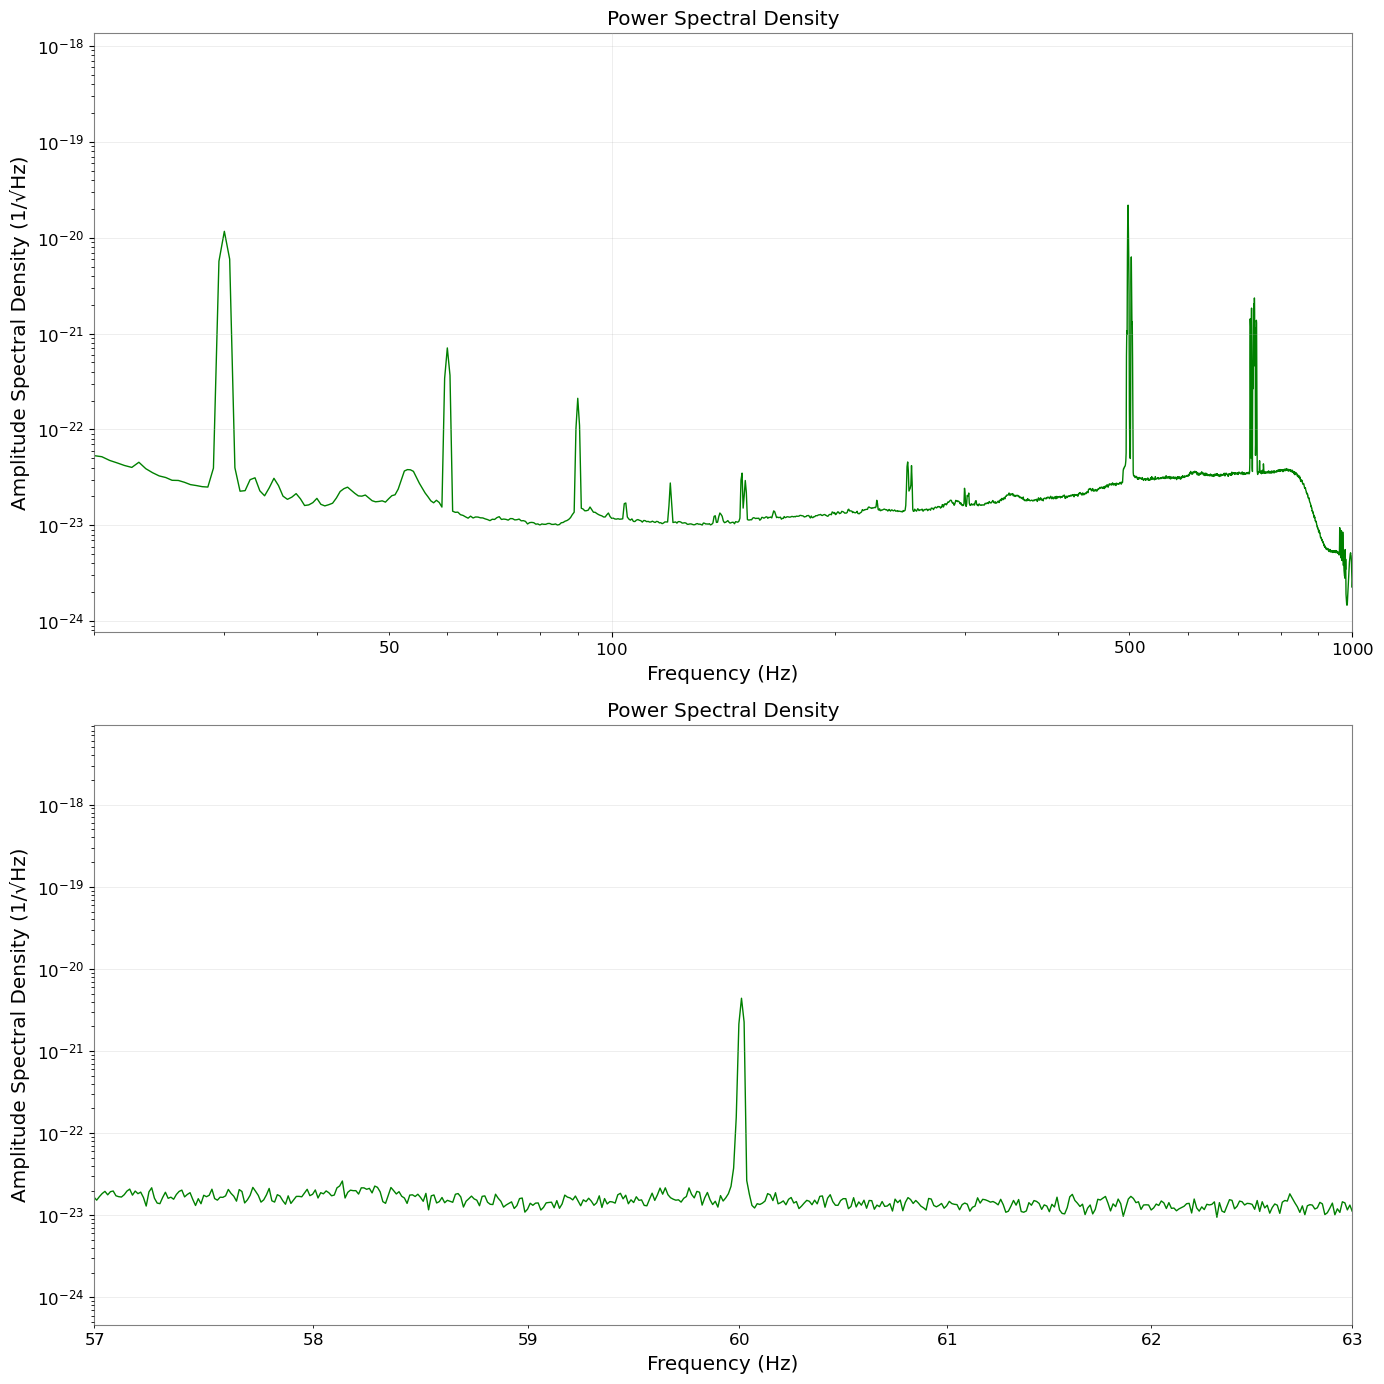

In [13]:
from gwpy.timeseries import TimeSeries
from src.utils import visualize_data

dataTS = TimeSeries(reconstructed, unit = 's', t0 = 0, dt = 1 / 2048)
visualize_data(dataTS)